# Phase 4 Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder, OrdinalEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, plot_confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/Users/meaghanross/Documents/Flatiron/Phase4/NLP_project/data/tweet_product_company.csv', encoding='latin1' )

In [4]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df.shape

(9093, 3)

In [6]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [7]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

To do

2) Fill nas for the brand
3) Label encode the target 
6) dropping 'I can't tell'
7) drop duplicates


In [8]:
df['target']=df['is_there_an_emotion_directed_at_a_brand_or_product']

In [9]:
df.drop('is_there_an_emotion_directed_at_a_brand_or_product',axis=1, inplace=True)

In [10]:
df['text']=df['tweet_text']

In [11]:
df.drop('tweet_text',axis=1, inplace=True)

In [12]:
df.shape

(9093, 3)

__Drop Duplicates__

In [13]:
df.duplicated().sum()

22

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.shape

(9071, 3)

In [16]:
df.dropna(subset=['text'], inplace=True)

In [17]:
df.target.value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: target, dtype: int64

In [18]:
df.text.isna().sum()

0

In [83]:
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag

In [87]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [136]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the review corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    tweet_token = TweetTokenizer()
    doc = tweet_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [89]:
df['tokenized'] = df['text'].apply(doc_preparer)

In [90]:
df.head()

,emotion_in_tweet_is_directed_at,target,text,tokenized
0,iPhone,Negative emotion,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,. @wesley83 3g iphone . 3 hr tweet #rise_austi...
1,iPad or iPhone App,Positive emotion,@jessedee Know about @fludapp ? Awesome iPad/i...,@jessedee know @fludapp ? awesome ipad / iphon...
2,iPad,Positive emotion,@swonderlin Can not wait for #iPad 2 also. The...,@swonderlin wait #ipad 2 also . sale #sxsw .
3,iPad or iPhone App,Negative emotion,@sxsw I hope this year's festival isn't as cra...,@sxsw hope year's festival crashy year's iphon...
4,Google,Positive emotion,@sxtxstate great stuff on Fri #SXSW: Marissa M...,@sxtxstate great stuff fri #sxsw : marissa may...


__Train-Test Split__

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df['tokenized'],
                                                    df['target'], 
                                                    random_state=42,
                                                    stratify=df['target'])

In [92]:
X_train.shape

(6802,)

__Data Cleaning__

For cleaning we want to drop 'I can't tell' after merging `X_train` with `y_train` and `X_test` with `y_test` to and Label Encode the target to numerical data.

In [93]:
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)

In [94]:
y_train.value_counts()

No emotion toward brand or product    4031
Positive emotion                      2227
Negative emotion                       427
I can't tell                           117
Name: target, dtype: int64

In [95]:
df_train.head()

,tokenized,target
2769,want one ! ! rumor : apple open temporary stor...,Positive emotion
2787,#aapl already big winner #sxsw { link } #in,No emotion toward brand or product
7021,@mention google's disavowal plan launch #sxsw .,No emotion toward brand or product
4882,anyone go buy new ipad donate #japan #tsunami ...,I can't tell
715,{ link } part presentation #sxsw good thing cr...,Positive emotion


In [96]:
def drop_unidentified(df):
    '''
    Drop rows from DataFrame where the target is 'I can't tell'.
    '''
    df.drop(df.loc[df['target']=="I can't tell"].index, inplace=True)
    return df

In [97]:
def label(df):
    '''
    Encode values of the target to numerical data.
    '''
    df['target'] = df['target'].map({'No emotion toward brand or product': 0,
                                     'Negative emotion': 1,
                                     'Positive emotion': 2})
    return df

In [98]:
cleaning_pipeline = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_unidentified)),
    ('label', FunctionTransformer(label))
])

In [99]:
df_train_clean = cleaning_pipeline.fit_transform(df_train)
df_test_clean = cleaning_pipeline.transform(df_test)

In [100]:
df_test_clean.head()

,tokenized,target
5039,rt @mention : aron pilhofer new york time endo...,0
643,"ok nerd , totally bateman . want sign ipad 2 ?...",0
4451,podcast social business summit 2011 austin { l...,2
177,#winning picture #android #google #sxsw { link },2
4980,team android sxsw  ûò full party detail revea...,2


## Model Iterations

In [101]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and multiclass target arrays using given pipeline, 
    printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print(results['test_accuracy'])
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('##############')
    print('Training Macro Precision:', results['train_precision_macro'].mean())
    print('Cross_Val Macro Precision:', results['test_precision_macro'].mean())
    print('##############')
    print('Training Macro Recall:', results['train_recall_macro'].mean())
    print('Cross_Val Macro Recall:', results['test_recall_macro'].mean())
    print('##############')
    print('Training Macro F1:', results['train_f1_macro'].mean())
    print('Cross_Val Macro F1:', results['test_f1_macro'].mean())


### FSM

In [142]:
sw = stopwords.words('english')

In [143]:
fsm_pipe = Pipeline([('cv', CountVectorizer(stop_words=sw,
                                            tokenizer=TweetTokenizer().tokenize)),
                     ('mnb', MultinomialNB())
])

In [144]:
fsm_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7ff662f9f220>>)),
                ('mnb', MultinomialNB())])

In [145]:
print_cv_scores(fsm_pipe, df_train_clean['tokenized'], df_train_clean['target'])

[0.8184368  0.81862378 0.81768886 0.82124159 0.82142857]
Training Accuracy 0.819483919222139
##############
[0.67614061 0.66192969 0.67988033 0.67539267 0.65669409]
Cross_Val Accuracy 0.6700074794315631
##############
Training Macro Precision: 0.8298981307235295
Cross_Val Macro Precision: 0.6515988234059547
##############
Training Macro Recall: 0.6860845759267238
Cross_Val Macro Recall: 0.4844948238017485
##############
Training Macro F1: 0.7283977455132726
Cross_Val Macro F1: 0.5023586198573182


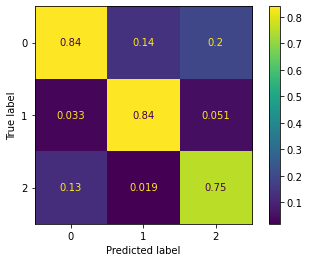

In [146]:
plot_confusion_matrix(fsm_pipe, 
                      df_train_clean['tokenized'], 
                      df_train_clean['target'], 
                      normalize='pred');

In [137]:
bayes_pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw,
                                                 tokenizer=TweetTokenizer().tokenize)),
                       ('mnb', MultinomialNB())
])

In [138]:
bayes_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7ff662f9a6d0>>)),
                ('mnb', MultinomialNB())])

In [139]:
print_cv_scores(bayes_pipe, df_train_clean['tokenized'], df_train_clean['target'])

[0.73429319 0.73448018 0.72643979 0.73130142 0.73859387]
Training Accuracy 0.7330216903515333
##############
[0.63500374 0.64248317 0.66118175 0.64921466 0.65071055]
Cross_Val Accuracy 0.6477187733732237
##############
Training Macro Precision: 0.808464526257521
Cross_Val Macro Precision: 0.4622833357140147
##############
Training Macro Recall: 0.46745805338800894
Cross_Val Macro Recall: 0.3858598431692813
##############
Training Macro F1: 0.4656582944694388
Cross_Val Macro F1: 0.356323715750439


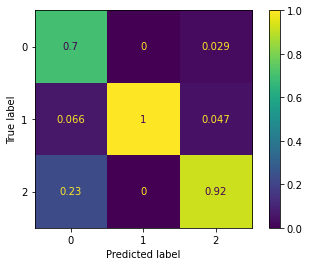

In [140]:
plot_confusion_matrix(bayes_pipe, 
                      df_train_clean['tokenized'], 
                      df_train_clean['target'], 
                      normalize='pred');

In [124]:
bayes_pipe[0].vocabulary_

{'want': 6922,
 'one': 4507,
 'rumor': 5443,
 'apple': 546,
 'open': 4524,
 'temporary': 6349,
 'store': 6061,
 'downtown': 2011,
 'austin': 669,
 'sxsw': 6196,
 'ipad': 3438,
 'launch': 3688,
 'link': 3790,
 'aapl': 270,
 'already': 441,
 'big': 874,
 'winner': 7035,
 'mention': 4067,
 'google': 2822,
 'disavowal': 1905,
 'plan': 4814,
 'part': 4648,
 'presentation': 4963,
 'good': 2816,
 'thing': 6413,
 'crash': 1621,
 'instead': 3379,
 'work': 7080,
 'best': 858,
 'iphone': 3445,
 'android': 487,
 'ipad2': 3439,
 'sell': 5580,
 '70': 222,
 'go': 2799,
 'new': 4349,
 'buyer': 1109,
 'wow': 7098,
 'via': 6833,
 'yesterday': 7155,
 'listen': 3799,
 'marissa': 3972,
 'mayer': 4019,
 'discus': 1917,
 'mobile': 4167,
 'technology': 6331,
 '40': 155,
 'user': 6771,
 'use': 6767,
 'maps': 3961,
 'phone': 4761,
 'nothing': 4419,
 'quite': 5122,
 'like': 3777,
 'make': 3935,
 'desperately': 1827,
 'almost': 434,
 'drool': 2031,
 'guy': 2928,
 'next': 4363,
 'everyone': 2281,
 'buy': 1108,
 'a

In [148]:
bayes_smote_pipe = imbpipe([
                            ('tfidf', TfidfVectorizer(stop_words=sw, 
                                                      tokenizer=TweetTokenizer().tokenize)),
                            ('smote', SMOTE(random_state=42,
                                            sampling_strategy = {0: 100, 
                                                                 1: 70, 
                                                                 2: 90})),
                            ('mnb', MultinomialNB())
])

In [149]:
bayes_smote_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7ff6758aa1f0>>)),
                ('smote', SMOTE(random_state=42)), ('mnb', MultinomialNB())])

In [150]:
print_cv_scores(bayes_smote_pipe, df_train_clean['tokenized'], df_train_clean['target'])

[0.79094989 0.77916978 0.78982797 0.78440539 0.78833209]
Training Accuracy 0.7865370231862379
##############
[0.61555722 0.57816006 0.62079282 0.61406133 0.56394914]
Cross_Val Accuracy 0.5985041136873598
##############
Training Macro Precision: 0.7100406611082108
Cross_Val Macro Precision: 0.5193945190053315
##############
Training Macro Recall: 0.8482809033481045
Cross_Val Macro Recall: 0.5936665577983826
##############
Training Macro F1: 0.74769029915003
Cross_Val Macro F1: 0.5314317024863692


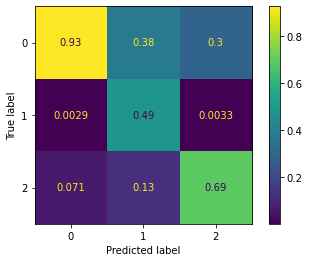

In [151]:
plot_confusion_matrix(bayes_smote_pipe, 
                      df_train_clean['tokenized'], 
                      df_train_clean['target'], 
                      normalize='pred');

In [152]:
xgb_pipe = imbpipe(steps=[('tfidf', TfidfVectorizer(stop_words=sw,
                                                    tokenizer=TweetTokenizer().tokenize)),
                          ('sm', SMOTE(random_state=42)),
                          ('xgb', XGBClassifier(random_state=42,
                                                max_depth = 6,
                                                n_jobs = -1))])

In [153]:
xgb_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_w

In [154]:
print_cv_scores(xgb_pipe, df_train_clean['tokenized'], df_train_clean['target'])

[0.87677636 0.87471952 0.86910995 0.86480927 0.87154076]
Training Accuracy 0.8713911742707555
##############
[0.67913239 0.6776365  0.67988033 0.69184742 0.67389678]
Cross_Val Accuracy 0.6804786836200449
##############
Training Macro Precision: 0.9154404725901131
Cross_Val Macro Precision: 0.604557150242045
##############
Training Macro Recall: 0.7737538803170918
Cross_Val Macro Recall: 0.49641646737697737
##############
Training Macro F1: 0.825486727374213
Cross_Val Macro F1: 0.5183603527849806


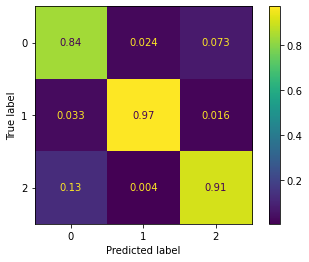

In [156]:
plot_confusion_matrix(xgb_pipe, 
                      df_train_clean['tokenized'], 
                      df_train_clean['target'], 
                      normalize='pred');

In [46]:
xgb_gs_pipe = imbpipe(steps=[('tfidf', TfidfVectorizer(stop_words=sw, 
                                                       token_pattern=r'(?u)\b[A-Za-z]+\b')),
                              ('sm', SMOTE(random_state=42)),
                              ('xgb', XGBClassifier(random_state=42,
                                                   n_jobs = -1,
                                                   max_depth=6,
                                                   tree_method= 'hist'))])

In [47]:
param_grid = [{'tfidf__max_features': [5000, None],
               'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]}]

gs_pipe = GridSearchCV(estimator=xgb_gs_pipe, 
                       param_grid=param_grid, 
                       verbose=2, 
                       scoring='precision_macro')

In [107]:
gs_pipe.fit(df_train_clean['text'], df_train_clean['target'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=  10.4s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=  10.3s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=  10.3s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=  10.2s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=  10.3s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=  14.2s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=  14.4s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=  14.2s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=  14.1s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=  13.8s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   5.0s
[CV] END tfidf__max_features=5000, tfidf__ngram_r

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                    

In [109]:
pd.DataFrame(gs_pipe.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__max_features,param_tfidf__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,10.256396,0.079050,0.029903,0.000230,5000,"(1, 1)","{'tfidf__max_features': 5000, 'tfidf__ngram_ra...",0.607171,0.570861,0.591048,0.614592,0.529008,0.582536,0.030687,3
1,14.087179,0.176503,0.040029,0.000235,5000,"(1, 2)","{'tfidf__max_features': 5000, 'tfidf__ngram_ra...",0.535832,0.584601,0.573057,0.623085,0.531591,0.569633,0.033712,4
2,4.915064,0.047946,0.030069,0.000142,5000,"(2, 2)","{'tfidf__max_features': 5000, 'tfidf__ngram_ra...",0.471193,0.494502,0.468016,0.491837,0.465145,0.478139,0.012449,6
3,11.468010,0.155647,0.029715,0.000118,None,"(1, 1)","{'tfidf__max_features': None, 'tfidf__ngram_ra...",0.625864,0.580207,0.586743,0.642704,0.561428,0.599389,0.030153,2
4,31.692422,0.462318,0.048071,0.000916,None,"(1, 2)","{'tfidf__max_features': None, 'tfidf__ngram_ra...",0.640050,0.597764,0.609489,0.692304,0.556106,0.619143,0.045417,1
5,16.301852,0.323872,0.036296,0.000367,None,"(2, 2)","{'tfidf__max_features': None, 'tfidf__ngram_ra...",0.596491,0.570866,0.552581,0.618080,0.506935,0.568991,0.038183,5


In [110]:
gs_pipe.best_score_

0.6191427132695128

In [191]:
idf_values = dict(zip(gs_pipe.best_estimator_[0].get_feature_names(), gs_pipe.best_estimator_[0].idf_))
[print(v) for i, v in enumerate(idf_values.items()) if i < 5]

('aapl', 7.610546489643824)
('aapl already', 9.114623886420098)
('aapl knows', 9.114623886420098)
('aapl link', 9.114623886420098)
('aapl open', 9.114623886420098)


[None, None, None, None, None]

In [112]:
max(gs_pipe.best_estimator_[0].idf_)

9.114623886420098

In [57]:
rf_SVD_pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw)),
                          ('svd', TruncatedSVD(n_components=30,
                                               random_state=42)),
                          ('rf', RandomForestClassifier(max_depth=12,
                                                        class_weight='balanced',
                                                        random_state=42))
])

In [55]:
print_cv_scores(rf_SVD_pipe, df_train_clean['text'], df_train_clean['target'])

[0.94596111 0.95381451 0.94839192 0.94932685 0.94970082]
Training Accuracy 0.9494390426327598
##############
[0.59311892 0.59685864 0.62976814 0.63724757 0.59237098]
Cross_Val Accuracy 0.6098728496634256
##############
Training Macro Precision: 0.8706077835003704
Cross_Val Macro Precision: 0.469670593090141
##############
Training Macro Recall: 0.9648250223260119
Cross_Val Macro Recall: 0.46365009368686644
##############
Training Macro F1: 0.9056831329137518
Cross_Val Macro F1: 0.463640255382877


In [63]:
param_grid = [{'svd__n_components': [100, 500, 1000],
               'rf__max_depth': [5, 10, 15]}]

gs_pipe = GridSearchCV(estimator=rf_SVD_pipe, 
                       param_grid=param_grid, 
                       verbose=2, 
                       scoring='precision_macro',
                       return_train_score=True)

In [64]:
gs_pipe.fit(df_train_clean['text'], df_train_clean['target'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .............rf__max_depth=5, svd__n_components=100; total time=   1.9s
[CV] END .............rf__max_depth=5, svd__n_components=100; total time=   1.8s
[CV] END .............rf__max_depth=5, svd__n_components=100; total time=   1.8s
[CV] END .............rf__max_depth=5, svd__n_components=100; total time=   1.8s
[CV] END .............rf__max_depth=5, svd__n_components=100; total time=   1.8s
[CV] END .............rf__max_depth=5, svd__n_components=500; total time=   6.2s
[CV] END .............rf__max_depth=5, svd__n_components=500; total time=   6.2s
[CV] END .............rf__max_depth=5, svd__n_components=500; total time=   6.2s
[CV] END .............rf__max_depth=5, svd__n_components=500; total time=   6.2s
[CV] END .............rf__max_depth=5, svd__n_components=500; total time=   6.3s
[CV] END ............rf__max_depth=5, svd__n_components=1000; total time=  14.8s
[CV] END ............rf__max_depth=5, svd__n_comp

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                    

In [65]:
pd.DataFrame(gs_pipe.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_svd__n_components,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.787059,0.039303,0.027843,0.000619,5,100,"{'rf__max_depth': 5, 'svd__n_components': 100}",0.451629,0.468082,0.473999,...,0.462382,0.013318,9,0.587005,0.567776,0.580988,0.577023,0.587144,0.579987,0.007202
1,6.195171,0.023649,0.031676,0.000268,5,500,"{'rf__max_depth': 5, 'svd__n_components': 500}",0.453384,0.473198,0.468341,...,0.470450,0.018959,8,0.662584,0.634029,0.656479,0.638764,0.678713,0.654114,0.016257
2,14.696884,0.049193,0.036631,0.000156,5,1000,"{'rf__max_depth': 5, 'svd__n_components': 1000}",0.481138,0.484475,0.481824,...,0.484245,0.011723,7,0.761865,0.699525,0.758547,0.745546,0.785676,0.750232,0.028474
3,2.794363,0.013056,0.032406,0.000247,10,100,"{'rf__max_depth': 10, 'svd__n_components': 100}",0.468117,0.482099,0.507326,...,0.484962,0.019515,6,0.827751,0.835881,0.827858,0.833400,0.869052,0.838788,0.015458
4,8.480714,0.115817,0.036625,0.000510,10,500,"{'rf__max_depth': 10, 'svd__n_components': 500}",0.602361,0.595001,0.628228,...,0.606348,0.037657,4,0.983659,0.975650,0.984790,0.983291,0.984994,0.982477,0.003474
5,17.635099,0.066001,0.040234,0.000213,10,1000,"{'rf__max_depth': 10, 'svd__n_components': 1000}",0.622484,0.642204,0.614015,...,0.651529,0.042376,3,0.989271,0.989608,0.990364,0.989204,0.989304,0.989550,0.000430
6,3.283544,0.032982,0.035952,0.000220,15,100,"{'rf__max_depth': 15, 'svd__n_components': 100}",0.516187,0.534408,0.536103,...,0.558015,0.049176,5,0.979271,0.987188,0.982832,0.988042,0.990974,0.985661,0.004124
7,9.692638,0.066331,0.041285,0.001855,15,500,"{'rf__max_depth': 15, 'svd__n_components': 500}",0.651235,0.638065,0.670096,...,0.672095,0.039197,1,0.995911,0.996722,0.996913,0.996805,0.995507,0.996372,0.000559
8,19.555878,0.078367,0.045110,0.000807,15,1000,"{'rf__max_depth': 15, 'svd__n_components': 1000}",0.622469,0.680738,0.637233,...,0.661688,0.038014,2,0.995869,0.997016,0.996572,0.996708,0.996099,0.996453,0.000415


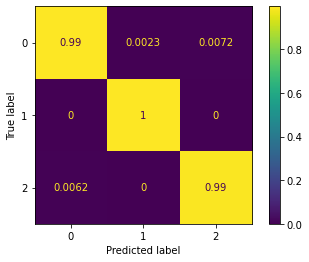

In [66]:
plot_confusion_matrix(gs_pipe.best_estimator_, 
                      df_train_clean['text'], 
                      df_train_clean['target'],
                      normalize='pred');

## Word2Vec Model

In [129]:
from gensim.models import Word2Vec
from nltk import word_tokenize
df_train_clean["new_column"] = df_train_clean['text'].str.replace('[^\w\s]','')
data = df_train_clean['new_column'].map(word_tokenize)



In [130]:
data[:5]

2769    [I, want, one, Its, not, a, rumor, Apple, is, ...
2787    [AAPL, already, the, big, winner, at, sxsw, li...
7021    [mention, Only, Googles, disavowal, of, its, p...
715     [So, link, is, part, of, my, presentation, at,...
4072    [iPad2, Sold, Out, 70, Went, to, New, Buyers, ...
Name: new_column, dtype: object

In [131]:
model = Word2Vec(data, size=100, window=5, min_count=1, workers=4)

model.train(data, total_examples=model.corpus_count, epochs=model.epochs)

(431013, 586135)

In [132]:
wv = model.wv

In [134]:
wv.most_similar('Apple')

[('shop', 0.9840596914291382),
 ('popup', 0.9822860360145569),
 ('sets', 0.9808186292648315),
 ('open', 0.9798450469970703),
 ('makeshift', 0.9779982566833496),
 ('Temp', 0.9774917364120483),
 ('quotpopupquot', 0.976834237575531),
 ('opens', 0.9750840067863464),
 ('311', 0.9743818044662476),
 ('temp', 0.9718767404556274)]

## EDA

In [113]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['text'].values.astype('U'))
total_df = pd.DataFrame(text_counts.todense(),columns = cv.get_feature_names())

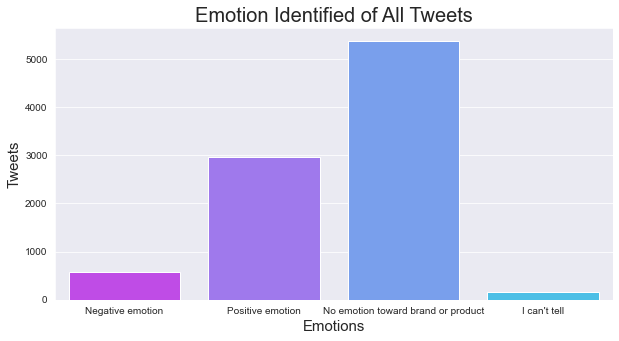

In [117]:
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
all_count_viz = sns.countplot(x=df['target'], palette='cool_r')
all_count_viz.set_title('Emotion Identified of All Tweets',fontsize = 20)
all_count_viz.set_xlabel('Emotions',fontsize = 15)
all_count_viz.set_ylabel('Tweets',fontsize = 15)
plt.show()

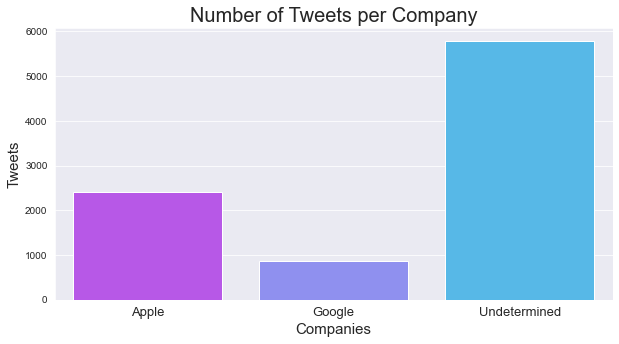

In [116]:
apple_products = ('iPhone', 'iPad or iPhone App', 'iPad','Apple','Other Apple product or service')
google_products = ('Google','Android','Android App','Other Google product or service')
def brand(x):
    if x in apple_products:
        return 'Apple'
    if x in google_products:
        return 'Google'
    else:
        return 'Neither'
df['brand'] = df['emotion_in_tweet_is_directed_at'].apply(brand)

# Plot resulting counts of tweet targets
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
brand_viz = sns.countplot(x=df['brand'], palette = 'cool_r')
brand_viz.set_title('Number of Tweets per Company',fontsize = 20)
brand_viz.set_xlabel('Companies',fontsize = 15)
brand_viz.set_ylabel('Tweets',fontsize = 15)
brand_viz.set_xticklabels(['Apple','Google', 'Undetermined'],fontsize = 13)
plt.show()

## Metrics